In [4]:
import json
import nltk
import urllib
import datetime as dt
import pandas as pd
import nltk
from datetime import timedelta
import seaborn as sns
import apyori
from apyori import apriori

from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing, metrics
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier

In [5]:
hike_data = pd.read_csv('gpx-tracks-from-hikr.org.csv')

In [6]:
hike_data.columns

Index(['_id', 'length_3d', 'user', 'start_time', 'max_elevation', 'bounds',
       'uphill', 'moving_time', 'end_time', 'max_speed', 'gpx', 'difficulty',
       'min_elevation', 'url', 'downhill', 'name', 'length_2d'],
      dtype='object')

In [7]:
# select needed columns - removing length_2d because it is the hike distance in meters on the 2d map
columns = ['length_3d', 'start_time', 'end_time', 'min_elevation', 'max_elevation', 'uphill', 'downhill', 'max_speed', 'difficulty']
hike_data = hike_data[columns]

# drop any rows with NAs in the time columns - hike duration is needed for the analysis and the data set is large
hike_data = hike_data.dropna(how='any')

# recast start time and end time as datetime objects
hike_data['start_time'] = pd.to_datetime(hike_data['start_time'], errors='coerce', format = '%Y-%m-%d %H:%M:%S')
hike_data['end_time'] = pd.to_datetime(hike_data['end_time'], errors='coerce', format = '%Y-%m-%d %H:%M:%S')

# only keep first two characters of difficulty column - we know the definitions of the designations
hike_data['difficulty'] = hike_data['difficulty'].str[:2]

# discretize difficulty value
hike_data['difficulty'] = hike_data['difficulty'].astype('category')

In [8]:
# derive values from existing columns

hike_data['duration'] = (hike_data['end_time'] - hike_data['start_time'])
hike_data['elevation_range'] = (hike_data['max_elevation'] - hike_data['min_elevation'])
hike_data['length_km'] = round(hike_data['length_3d'].astype(float), 3) / 1000

In [9]:
# convert duration to seconds
hike_data['duration'] = hike_data['duration'].dt.seconds

In [10]:
# dicard any remaining rows with nulls
hike_data = hike_data.dropna(how='any')

In [11]:
# drop any duplicates
hike_data = hike_data.drop_duplicates()

In [12]:
hike_data.shape

(7346, 12)

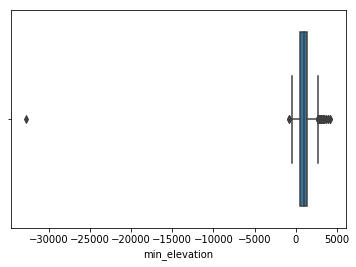

In [13]:
# check for outliers using boxplots

sns.boxplot(x = hike_data['min_elevation'])

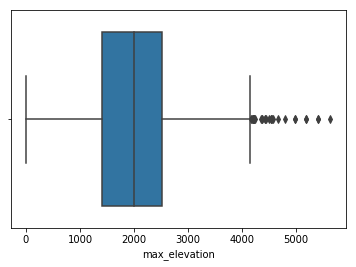

In [14]:
sns.boxplot(x = hike_data['max_elevation'])

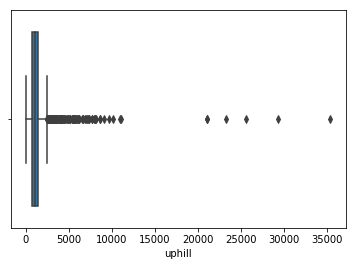

In [15]:
sns.boxplot(x = hike_data['uphill'])

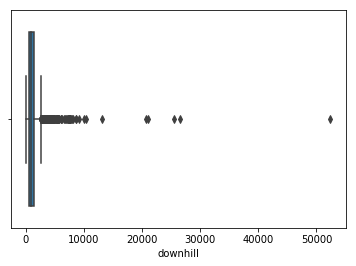

In [16]:
sns.boxplot(x = hike_data['downhill'])

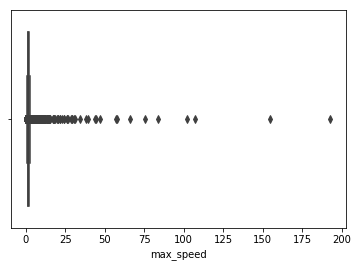

In [17]:
sns.boxplot(x = hike_data['max_speed'])

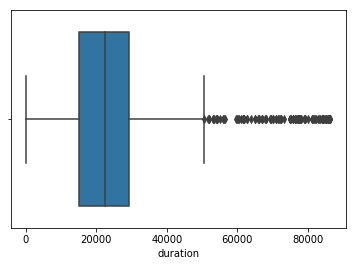

In [18]:
sns.boxplot(x = hike_data['duration'])

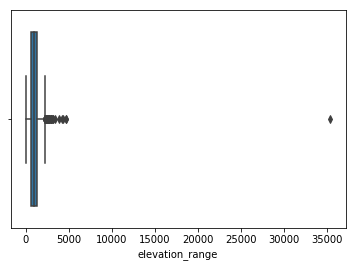

In [19]:
sns.boxplot(x = hike_data['elevation_range'])

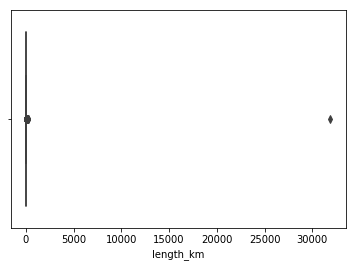

In [20]:
sns.boxplot(x = hike_data['length_km'])

In [21]:
# Remove extreme outliers
hike_data = hike_data.drop(hike_data[hike_data.length_km > 300.0].index)
hike_data = hike_data.drop(hike_data[hike_data.max_speed > 150.0].index)
hike_data = hike_data.drop(hike_data[hike_data.elevation_range > 3000.0].index)
hike_data = hike_data.drop(hike_data[hike_data.max_speed == 0.0].index)
hike_data = hike_data.drop(hike_data[hike_data.downhill > 15000].index)
hike_data = hike_data.drop(hike_data[hike_data.uphill > 15000].index)

In [22]:
# see how much data is left

hike_data.shape

(7211, 12)

In [23]:
# only use columns needed for statistics and models
columns = ['max_speed', 'length_km', 'duration', 'elevation_range', 'uphill','downhill', 'difficulty']
hd = hike_data[columns]

In [24]:
## SUMMARY STATISTICS

In [25]:
hd.describe()

,max_speed,length_km,duration,elevation_range,uphill,downhill
count,7211.000000,7211.000000,7211.000000,7211.000000,7211.000000,7211.000000
mean,2.002001,14.438936,22701.388712,948.338331,1092.586950,1024.532703
std,3.286700,10.756578,11135.431570,468.805099,707.352650,741.914197
min,0.481589,0.968657,0.000000,0.000000,0.000000,0.000000
25%,1.282566,9.186569,15278.000000,618.020000,676.766500,584.127500
50%,1.440419,12.724665,22720.000000,930.000000,1020.400000,965.169000
75%,1.690176,17.172863,29274.000000,1260.927000,1396.370002,1367.245500
max,107.172451,226.907817,86386.000000,2967.400146,11093.970000,10408.600000


In [26]:
hd.head()

,max_speed,length_km,duration,elevation_range,uphill,downhill,difficulty
0,1.595493,10.832953,14443.0,611.51,612.880,609.670,T2
1,1.394320,12.259376,17000.0,919.81,614.753,1193.733,T3
2,1.503002,22.980168,32585.0,2088.46,2255.976,2177.626,T3
3,1.516689,24.903503,32936.0,573.91,882.312,901.052,T2
4,1.542405,19.581274,25767.0,259.07,310.662,305.372,T2


In [27]:
hd['difficulty'].value_counts()

T3    2575
T2    2233
T4    1081
T1     570
T5     554
T6     198
Name: difficulty, dtype: int64

In [28]:
# Create a train/test split

cols = [col for col in hd if col not in ['difficulty']]
ycols = [col for col in hd if col in ['difficulty']]
hike_predictors = hd[cols]
hike_target = hd[ycols]

trainX, testX, trainY, testY = train_test_split(hike_predictors,\
                                                hike_target,\
                                                test_size = 0.20,\
                                                random_state=10)

In [29]:
# verify target dataframe only includes the target variable
for col in hike_target.columns:
    print(col)

difficulty


In [30]:
# check the size of the train and test splits
print(trainX.shape, trainY.shape, testX.shape, trainY.shape)

(5768, 6) (5768, 1) (1443, 6) (5768, 1)


In [31]:
# Naive Bayes

# Create a naive Bayes object
gnb = GaussianNB()
# Train the algorithm and form a predictive model
modelNB = gnb.fit(trainX, trainY.values.ravel())
predNB= modelNB.predict(testX)
# Test the model and report the accuracy score
print("Naive Bayes accuracy:", round(accuracy_score(testY, predNB, normalize=True)*100, 2), "\b%")

# with 5-fold cross-validation
scoreNBcv05 = cross_val_score(modelNB, trainX, trainY.values.ravel(), cv=5)
print("Naive Bayes accuracy, 5-fold cross-validation: ", round(scoreNBcv05.mean()*100, 2), "\b%")

Naive Bayes accuracy: 44.14 %
Naive Bayes accuracy, 5-fold cross-validation:  41.97 %


In [32]:
# K-Nearest Neighbors

# Creat a KNN Object
knn = KNeighborsClassifier(n_neighbors=10)
# Train the algorithm and form a predictive model
modelKNN = knn.fit(trainX, trainY.values.ravel())
predKNN = modelKNN.predict(testX)
# Test the model and report the accuracy score
print("K-Nearest Neighbors accuracy: ", round(accuracy_score(testY, predKNN, normalize=True)*100, 2), "\b%")

# With 5-fold cross-validation
scoreKNNcv05 = cross_val_score(modelKNN, trainX, trainY.values.ravel(), cv=5)
print("K-Nearest Neighbors accuracy, 5-fold cross-validation: ", round(scoreKNNcv05.mean()*100, 2), "\b%")

K-Nearest Neighbors accuracy:  45.39%
K-Nearest Neighbors accuracy, 5-fold cross-validation:  43.98%


In [33]:
# Multinomial Logistic Regression

mlr_model = linear_model.LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg')
modelMLR = mlr_model.fit(trainX, trainY.values.ravel())
predMLR = modelMLR.predict(testX)
print("Multinomial Logistic Regression accuracy: ", round(accuracy_score(testY, predMLR, normalize=True)*100, 2), "\b%")

# With 5-fold cross-validation
scoreMLRcv05 = cross_val_score(modelMLR, trainX, trainY.values.ravel(), cv=5)
print("Multinomial Logistic Regression accuracy, 5-fold cross-validation: ", round(scoreMLRcv05.mean()*100, 2), "\b%")

C:\Users\madmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


Multinomial Logistic Regression accuracy:  49.0 %


C:\Users\madmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\madmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\madmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\madmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


Multinomial Logistic Regression accuracy, 5-fold cross-validation:  48.11 %


C:\Users\madmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [34]:
# Random Forest

# Create a Random Forest object
RF = RandomForestClassifier()
# Train the algorithm and form a predictive model
modelRF = RF.fit(trainX, trainY.values.ravel())
predRF = modelRF.predict(testX)
print("Random Forest accuracy:", round(accuracy_score(testY, predRF, normalize=True)*100, 2), "\b%")

# With 5-fold cross-validation
scoreRFcv05 = cross_val_score(modelRF, trainX, trainY.values.ravel(), cv=5)
print("Random Forest accuracy, 5-fold cross-validation: ", round(scoreRFcv05.mean()*100, 2), "\b%")

C:\Users\madmo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest accuracy: 44.77%
Random Forest accuracy, 5-fold cross-validation:  44.97%
